# Bayesian Decision Theory 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import sys

import scipy.stats

## Bayesian Decision Rules for Classification

Classification problem: Discriminate between healthy people and people with anemia, where we assume that 90% of population is healthy, and 10% has anemia. We also assume that only one variable(feature x) impacts the class of the person (c1=healthy, c2=anemia), red blood cell count (in millions). Data likelihood given class information is as follows:
 - $(x|c1)\sim N(\mu=5.5, \sigma^2 = 0.75^2)$
 - $(x|c2)\sim N(\mu=3.0, \sigma^2 = 1.4^2)$
 
Given the observation $x=3.5$, what is the class of the patient?

**Prior class probabilities**

In [2]:
pi_1 = 0.9
pi_2 = 0.1

**Likelihood**

In [3]:
from scipy.stats import norm

def plot_normal(gloc, gscale):
    x = np.linspace(0,8,1000)
    y = norm.pdf(x, loc=gloc, scale=gscale)    # for example
    plt.plot(x,y)
    axes = plt.gca()
    axes.set_ylim([0,0.6])
    plt.show()

In [4]:
# assume normal distribution
x_c1_mu = 5.5
x_c1_sigma = 0.75
x_c2_mu = 3.0
x_c2_sigma = 1.4
x_obs = 3.5

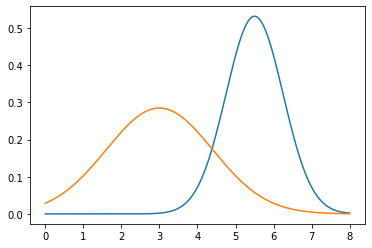

In [5]:
x = np.linspace(0,8,1000)
y1 = norm.pdf(x, loc=x_c1_mu, scale=x_c1_sigma)
y2 = norm.pdf(x, loc=x_c2_mu, scale=x_c2_sigma)
plt.plot(x,y1)
plt.plot(x,y2)
plt.show()

### Finding a decision boundary

In [6]:
# iterate over search_range to find a decision boundary at which class value changes (e.g. from c2 to c1)
def find_decision_boundery( c1_mu , c1_sigma , c1_prior , c2_mu , c2_sigma , c2_prior ,  obs_range ):    
    decision_boundary = 0    
    for obs_x in obs_range:
      
        #P(x|C1).P(C1) or likelihood
        c1_pdf = scipy.stats.norm(c1_mu, c1_sigma).pdf(obs_x)
        c1_posterior = np.round( c1_pdf * c1_prior , 3)
        
        #P(x|C2).P(C2) or likelihood
        c2_pdf = scipy.stats.norm(c2_mu, c2_sigma).pdf(obs_x)
        c2_posterior = np.round( c2_pdf * c2_prior , 3)
        
        # P(C1|x) > P(C2|x) ~ P(x|C1).P(C1) > P(x|C2).P(C2)
        if(c1_posterior >= c2_posterior):
            decision_boundary = obs_x
            break
            
    return decision_boundary

### Error calculation

In [7]:
# iterate over search_range to find min error and report the corresponding x_obs value
# see lecture notes for error formula
def calculate_error (c1_mu , c1_sigma , c1_prior , c2_mu , c2_sigma , c2_prior ,  obs_range):
    
    min_error = 1
    min_obs_x = 0
    
    for obs_x in obs_range:
        new_error = 0
        
        c1_cdf =scipy.stats.norm(c1_mu, c1_sigma).cdf(obs_x)
        new_error += (c1_cdf * c1_prior)
        
        c2_cdf =  scipy.stats.norm(c2_mu, c2_sigma).cdf(obs_x)
        new_error += (1 - c2_cdf) * c2_prior 
 
        if new_error < min_error :                                 
            min_error = new_error
            min_obs_x = obs_x
    return np.round(min_error,3), min_obs_x
    

In [8]:
# generate range of values to do line search over the possible values of x_obs
search_range = np.arange(0.0, 8.0, 0.01)
decision_boundary = find_decision_boundery( x_c1_mu, x_c1_sigma, pi_1, x_c2_mu, x_c2_sigma, pi_2, search_range)
error, min_x  = calculate_error( x_c1_mu, x_c1_sigma, pi_1, x_c2_mu, x_c2_sigma, pi_2, search_range)
print("Decision Boundary: ",decision_boundary)
print("Min error:", error)
print("Value X:", min_x)

Decision Boundary:  3.68
Min error: 0.038
Value X: 3.68


## Discriminant Functions 

$\textbf{(a) Generate a toy classification problem dataset for the cartesian coordinate system with two classes (K=2).}$
1. Pick two random cluster center coordinates.
2. For each cluster center, generate 20 data points (samples) by adding random noise values to cluster center values.
3. Store dataset X along with ground truth label values for each sample.
4. Shuffle the dataset (randomize the order of samples in your dataset).

**1. Pick Centers**

In [9]:
center1_x = 8
center1_y = 10

center2_x = 9
center2_y = 11

**Place centers into a dictionary for later**

In [10]:
centers_dict = {}
centers_dict[(center1_x,center1_y)] = "class1"
centers_dict[(center2_x,center2_y)] = "class2"
centers_dict

{(8, 10): 'class1', (9, 11): 'class2'}

**2. Generate 20 data points as noise around each center**

In [11]:
np.random.seed(0)
sample_x_1 = np.random.uniform(center1_x-1, center1_x+1, 20)
sample_x_2 = np.random.uniform(center2_x-1, center2_x+1, 20)

sample_y_1 = np.random.uniform(center1_y-1, center1_y+1, 20)
sample_y_2 = np.random.uniform(center2_y-1, center2_y+1, 20)

**3. Place dataset with ground truth **

In [12]:
data_dict = {}

for i in range(0,20):
    new_tuple = (sample_x_1[i],sample_y_1[i])
    data_dict[new_tuple] = "class1"
    
for i in range(0,20):
    new_tuple = (sample_x_2[i],sample_y_2[i])
    data_dict[new_tuple] = "class2"

**4. shuffle the data points **

In [13]:
datapoints = list(data_dict.keys())
random.shuffle(datapoints)

$\textbf{(b) Assuming P(C_i | x) is correlated with Euclidean distance between the class center and data point.}$
1. Calculate prediction g(x) for each data point.
2. Report correct classification and misclassification counts.

**1. Calculate prediction g(x) for each data point.**

In [14]:
def  euclidean_distance(center_x , center_y , point_x , point_y ):
    distance_x = math.pow(point_x - center_x ,2)
    distance_y = math.pow(point_y - center_y ,2)
    distance = math.sqrt(distance_x + distance_y)
    return np.round(distance, 3)


def class_prediction(centers_dict , datapoint):
   
    current_distance = sys.maxsize
    current_class = ""
    
    for center , value in centers_dict.items():
        distance = euclidean_distance(center[0] , center[1], datapoint[0], datapoint[1])
        if distance < current_distance:
            current_distance = distance
            current_class = value
            
    return current_class

In [15]:
import sys

predicted_dic = {}
for point in datapoints:
    pre_class = class_prediction(centers_dict , point)
    predicted_dic[point] = pre_class


**2. Report on correct and incorrect classifications**

In [16]:
n = len(predicted_dic)
correct = 0 

for i in predicted_dic:
    if data_dict[i] == predicted_dic[i]:
        correct += 1
    
    
print("{} correct discriminent of {} data points".format(correct, n))

38 correct discriminent of 40 data points


$\textbf{(c) Plot dataset along with predictions.}$

1. Plot color coded cluster centers.
2. Plot generated data points, where color of the data points represent predicted cluster.

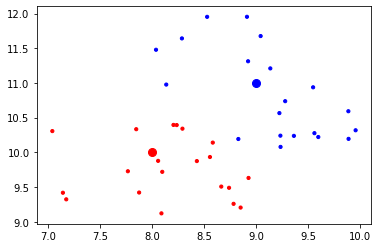

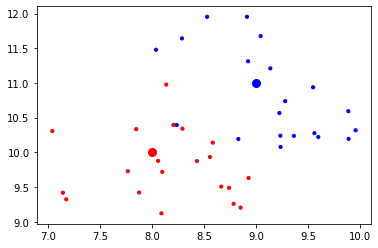

In [17]:

x =[]
y=[]
centers =[]
for  item , value in predicted_dic.items():
    x.append(item[0])
    y.append(item[1])
    centers.append( 'r' if value == 'class1' else 'b' )

plt.plot(center1_x,center1_y,"ro" , markersize= 8)
plt.plot(center2_x,center2_y,"bo" , markersize= 8)
plt.scatter(x,y, c= centers , s= 10)
plt.show()


xa =[]
ya =[]
centersa =[]
for  item , value in data_dict.items():
    xa.append(item[0])
    ya.append(item[1])
    centersa.append( 'r' if value == 'class1' else 'b' )
    
plt.plot(center1_x,center1_y,"ro" , markersize= 8)
plt.plot(center2_x,center2_y,"bo" , markersize= 8)
plt.scatter(xa,ya, c= centersa , s= 10)
plt.show()